## Advanced Lane Line

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Compute the camera calibration using chessboard images

In [1]:
#import packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib inline
#%matplotlib qt

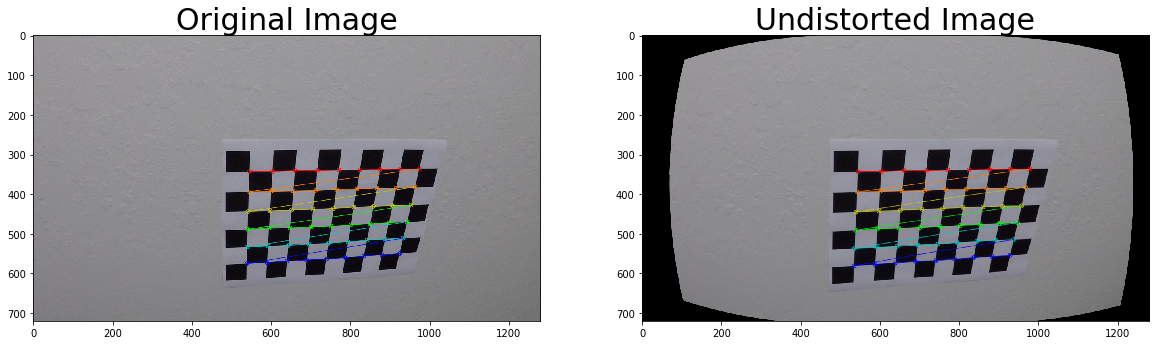

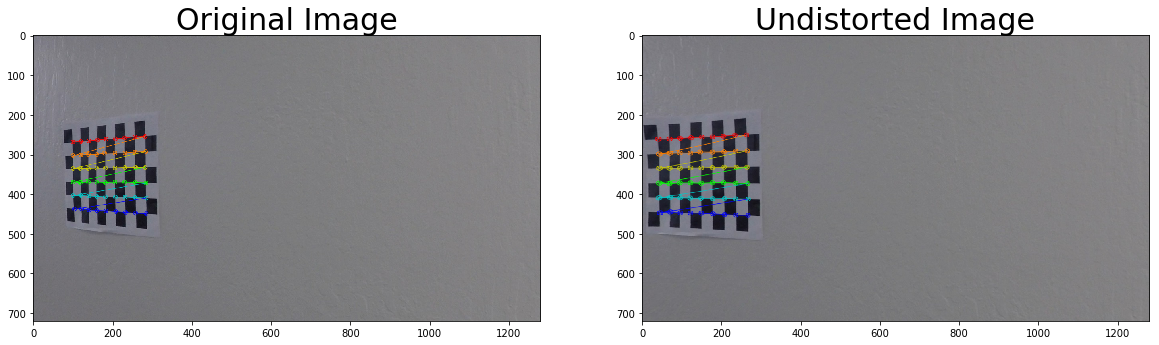

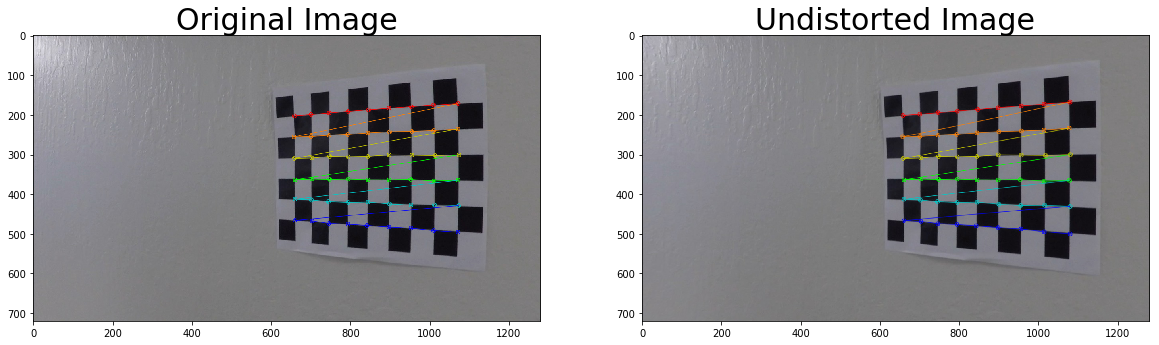

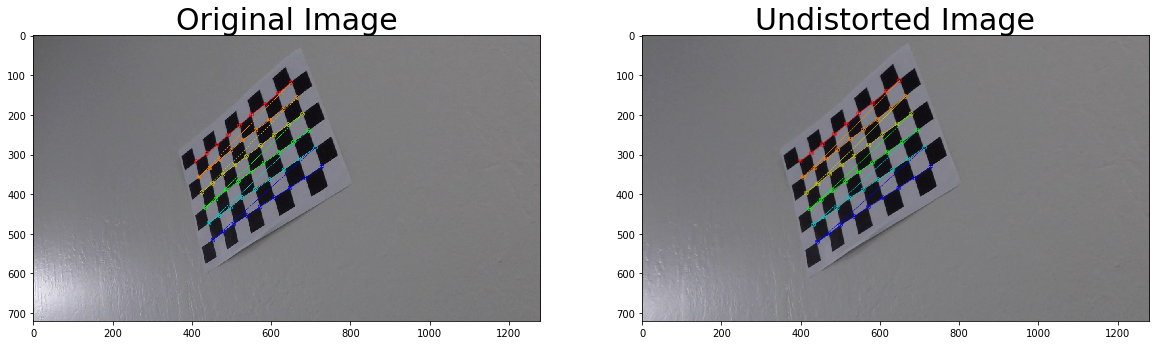

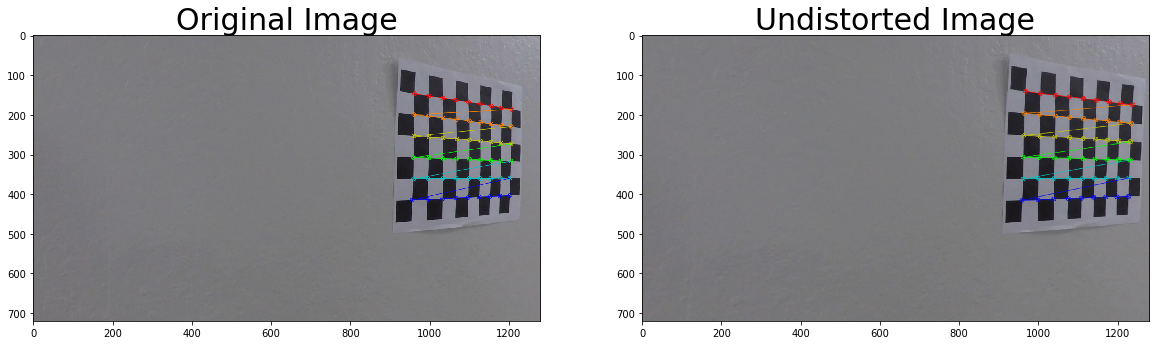

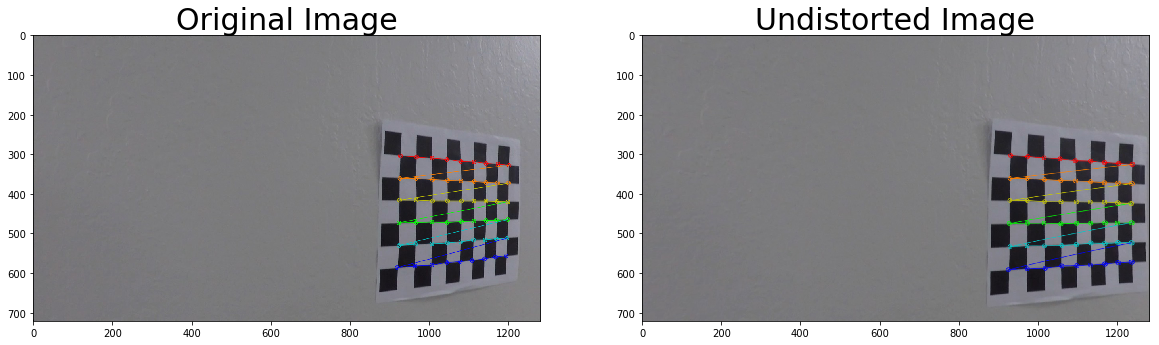

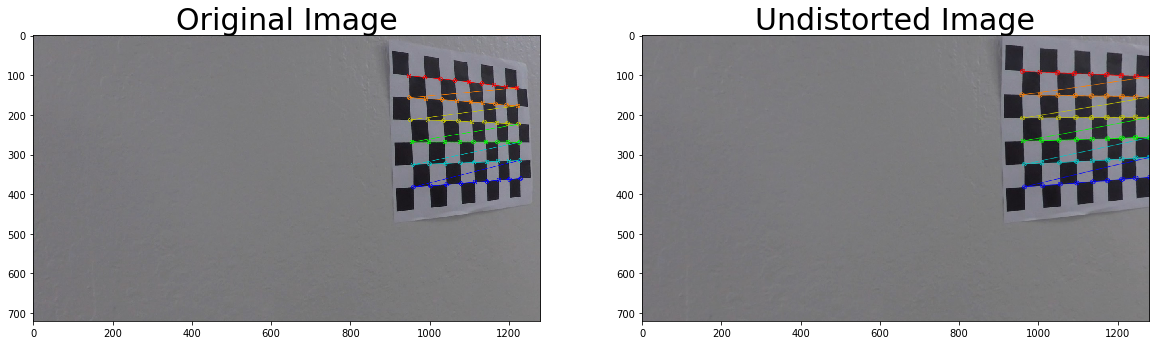

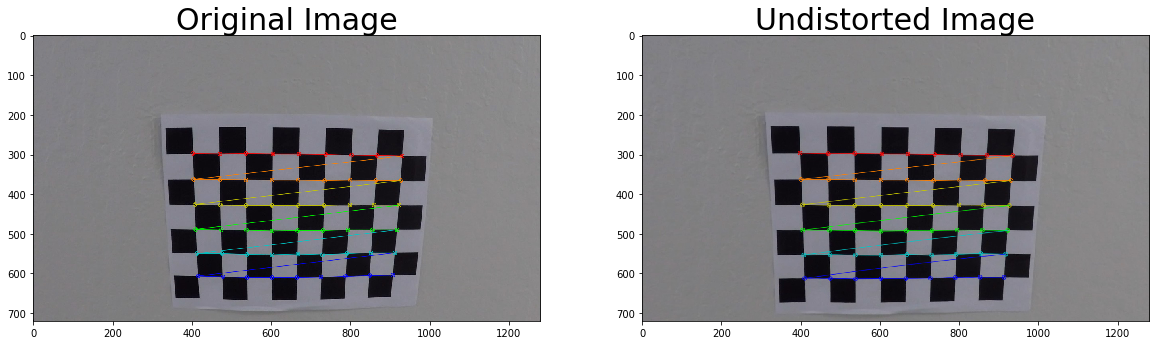

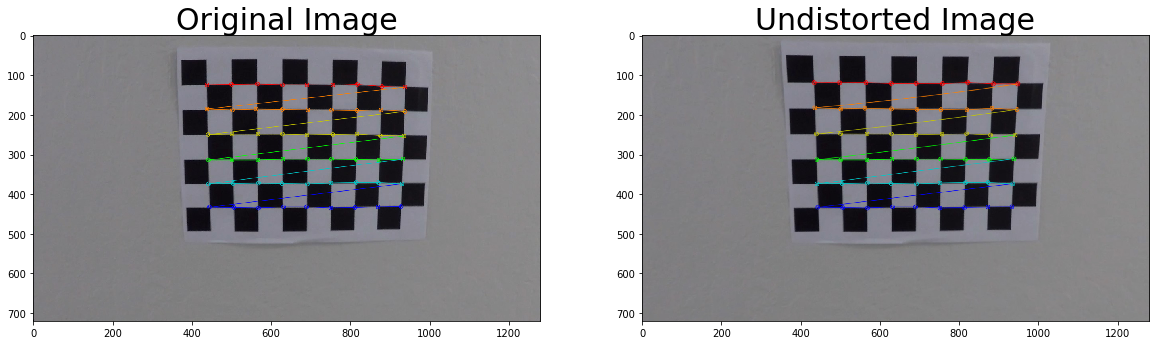

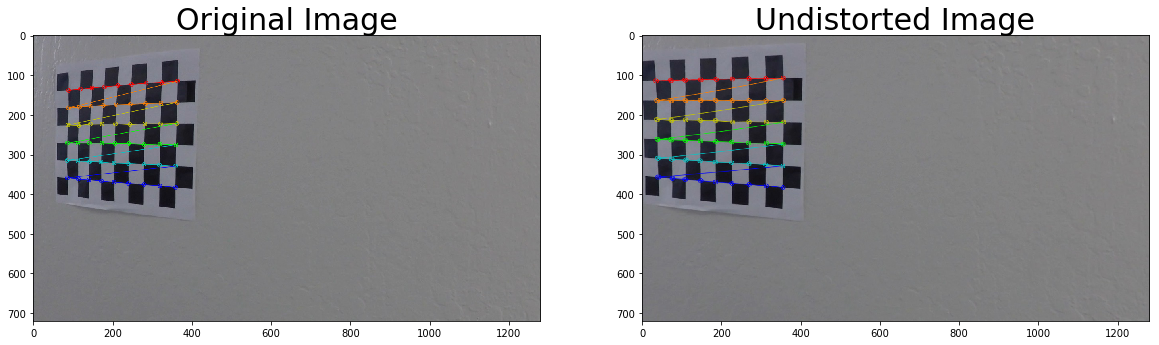

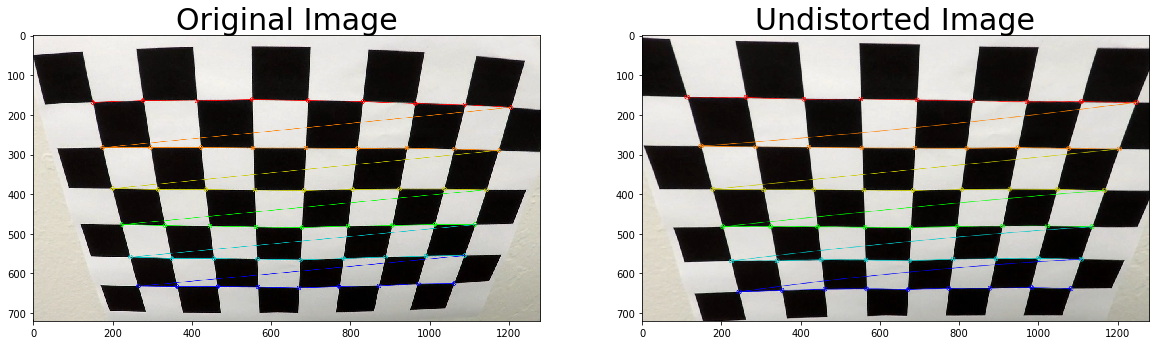

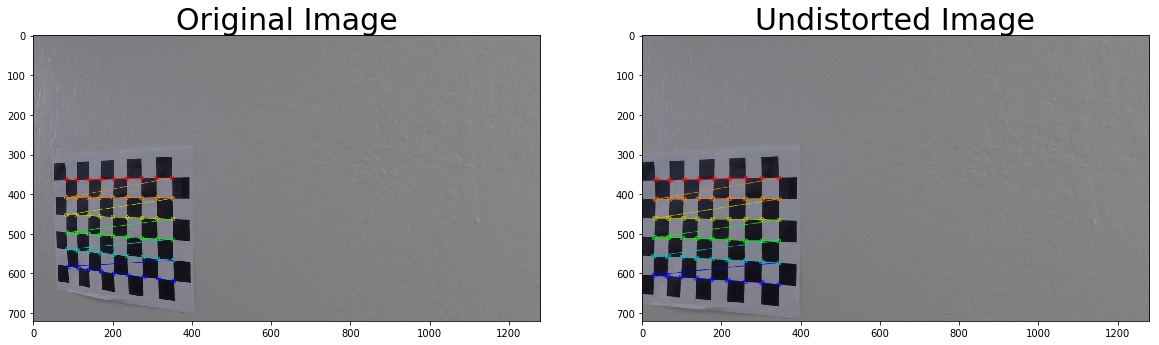

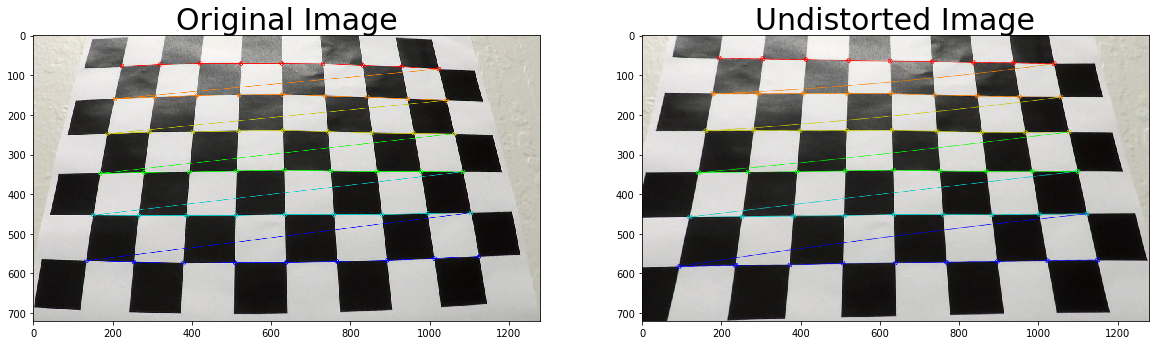

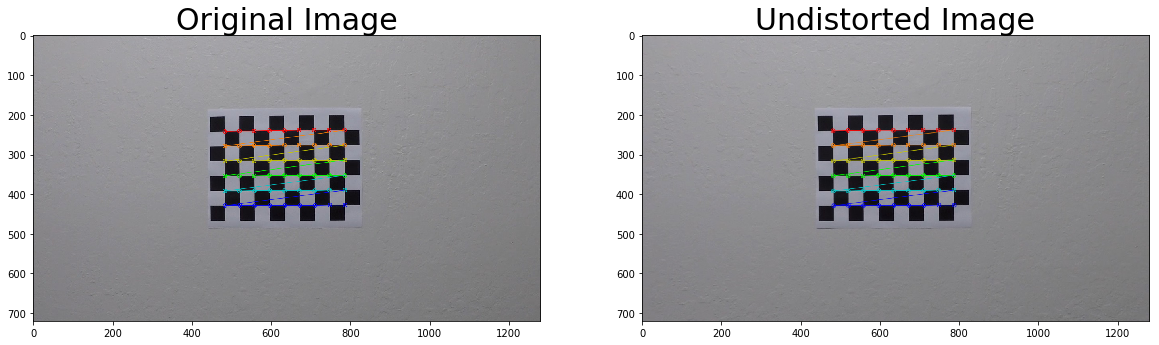

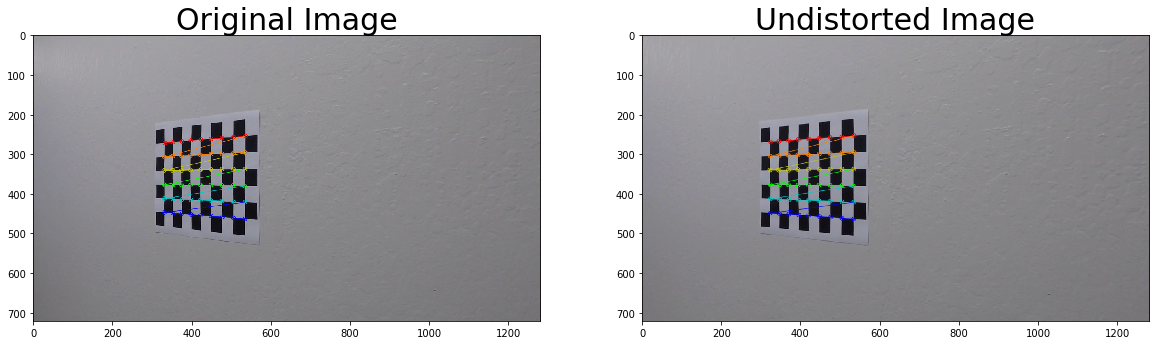

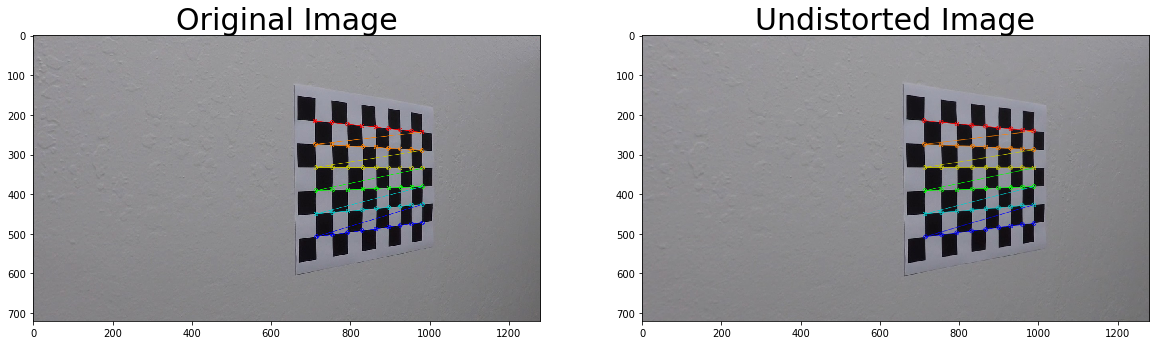

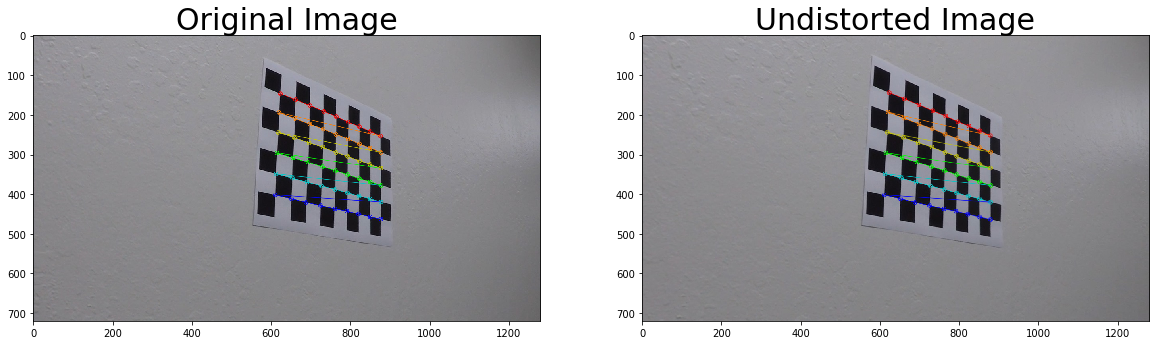

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        
        # Test undistortion on an image
        #img = cv2.imread(fname)        
        img_size = (img.shape[1], img.shape[0])
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        oname = './output_images/undist_calibration'+str(idx) + '.jpg'
        #cv2.imwrite('../Project4/CarND-Advanced-Lane-Lines/output_images/undist_calibration1.jpg',dst)
        cv2.imwrite(oname,dst)
        # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open( "./output_images/cal_dist_pickle.p", "wb" ) )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=30)

In [3]:
#Load undistortion data

data = pickle.load( open( "./output_images/cal_dist_pickle.p", "rb" ) )
mtx  = data['mtx']
dist = data['dist']


### Define Helper Function

In [4]:
def birds_eye(img):
    imshape =img.shape
    src = np.float32([[0.1*imshape[1],0.9*imshape[0]],[0.415*imshape[1], 
                             0.65*imshape[0]], [0.585*imshape[1], 0.65*imshape[0]],
                               [0.9*imshape[1],0.9*imshape[0]]])
    dst = np.float32([[0, imshape[0]],[0, 0], [imshape[1],0], 
                                     [imshape[1], imshape[0]]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = np.linalg.inv(M)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped, Minv

def  color_space(img):
    '''
    
    Applies HSV,HSL transfrom with Sobel Operator to extract lane line.
    
    '''
    sx_thresh=(50, 255)
    
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # For yellow
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))

    # For white
    sensitivity_1 = 68
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

    sensitivity_2 = 65
    HSL = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = HSL[:,:,1]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    white_3 = cv2.inRange(img, (200,200,200), (255,255,255))
    
    gray = cv2.bitwise_or(yellow, white)
    
    bit_layer = gray | white_2 | white_3 | sxbinary
    return bit_layer


def fitting_curve(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result

    out_img = np.zeros((720,1280,3), np.uint8)
    out_img = np.dstack((img, img, img))*255
    #plt.imshow(out_img)
    #print(out_img.shape)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
      
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    '''
    #Visualize
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 27/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    #Estimate distance
    #print(left_fitx,right_fitx)
    left_x_distance = left_fitx[np.max(left_fitx[:])]
    left_distance = (1260 // 2 - left_x_distance) * xm_per_pix
    #print(left_distance)

    return ploty, left_fitx, right_fitx,  left_curverad, right_curverad, left_distance


def Draw_lane(dst, warped, Minv, ploty, left_fitx, right_fitx,  left_curverad, right_curverad, left_distance):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)

    text_l = "left radius: " + str(np.round(left_curverad)) 
    text_r = " right radius: " + str(np.round(right_curverad))    
    cv2.putText(result, text_l, (20, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
    cv2.putText(result, text_r, (400, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
    
    if (1.85-left_distance) < 0:
        text_pos = "Vehicle Position: " + str(np.absolute(np.round((1.85-left_distance), 2))) + " m left of center"
        cv2.putText(result, text_pos, (20, 80), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
    elif (1.85-left_distance) > 0:
        text_pos = "Vehicle Position: " + str(np.absolute(np.round((1.85-left_distance), 2))) + " m right of center"
        cv2.putText(result, text_pos, (20, 80), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
    else:
        text_pos = "Vehicle Position: " + "at the center"
        cv2.putText(result, text_pos, (20, 80), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2) 
    
    
    return result
        

### Building Pipeline

In [5]:
def pipeline(img):
    img = cv2.resize(img,(1280,720),interpolation=cv2.INTER_CUBIC)
    #BRG2RGB Transform if use cv2.imread 
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Undistort image
    img_size = (img.shape[1], img.shape[0])
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #Perspective Transform
    warped,Minv = birds_eye(dst)
    #Color Mask
    mask = color_space(warped)
    #Fitting curve and estimate curvature
    ploty, left_fitx, right_fitx,  left_curverad, right_curverad, left_distance = fitting_curve(mask)
    #Drawing
    result = Draw_lane(dst, mask, Minv, ploty, left_fitx, right_fitx,  left_curverad, right_curverad, left_distance)
    #result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result
    
    
    

### Test Pipeline for image

C:\Users\Tony\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Tony\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:161: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


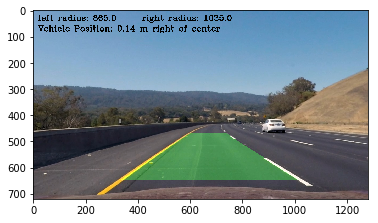

In [6]:
#Test 
img = mpimg.imread('test_images/test3.jpg')
img = pipeline(img)
plt.imshow(img)

### Test Pipeline for Video

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [8]:
#Make directory for output
indir = "test_videos"
outdir = indir + "_output"
if os.path.isdir(outdir):
    pass
else:
    os.mkdir(outdir)

#Video Processing 
yellow_output = 'test_videos_output/project_video.mp4'
clip2 = VideoFileClip('test_videos/project_video.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|██████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:51<00:00, 11.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 1min 51s
